## The "Where" of Dry
### *Spatiotemporal Tracking of Agricultural Droughts*

Drew Phillips, Earth Data Analytics Applications Summer 2020

### *Overview*

How are we affected by droughts? For many of us, droughts manifest as wildfire bans or instructions to leave our pools unfilled. In industrialized countries, however, we are spared many of the catastrophic downstream effects of droughts including impacts on public health and the economy.

The [U.S. Drought Monitor](https://droughtmonitor.unl.edu/) produces daily maps of the spatial extent and severity of droughts in the United States. However, the boundaries and are somewhat arbitrary and the analysis is not reproducible since it depends on expert judgment of quantitative data.

With these issues in mind, I chose this project to answer the following question:
> How can we accurately describe the spatial extent of a droughted region on a local scale?

In [1]:
import os
from pathlib import Path
import warnings

# Analysis and graphing libs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches 

# Spatial libs
import geopandas as gpd
from shapely.geometry import Polygon

# libs for aWhere API
import requests as rq
from header import AWhereAPI
from secret_codes import *

# Secret API info
api_key = API_KEY
api_secret = API_SECRET

warnings.simplefilter("ignore")

In [2]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

In [3]:
# Set variables for aWhere API call 

# General endpoint
endpt = "https://api.awhere.com"

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": "application/json"}

agro_header = {"Authorization":  "Bearer %s" % token}

In [4]:
# Set path to are of interst (in same directory)
# In this instance, AoI is Josephine County
path_to_aoi = r"josephine_4326.geojson"

# Read in area of interest (in this case, shapefile
# of Josephine County, OR)
aoi = gpd.read_file(path_to_aoi)

# Ensure AoI is in WGS84
aoi = aoi.to_crs("EPSG:4326")

In [5]:
def create_grid(study_area_path, buffer_distance, cell_size=0.08):
    """
    Creates an aWhere-sized grid (0.08 x 0.08 degree,
    5 arc-minute x 5 arc-minute grid) fit to a polygon.

    Parameters
    ----------
    study_area_path : str
        Path the polygon shapefile boundary.

    buffer_distance : int or float
        Buffer size in degrees (WGS 84 CRS).

    cell_size: int or float
        Grid size (x and y dimension) in degrees (WGS 84 CRS).

    Returns
    -------
    study_area_grid_4326: geopandas GeoDataFrame
        Grid dataframe shaped to the polygon boundary.

    study_area_4326: geopandas GeoDataFrame
        Study area boundary projected to WGS 84, EPSG 4326.
    """
    
    # Read shapefile into geodataframe
    study_area = gpd.read_file(study_area_path)

    # Project to WGS 84 Lat/Lon, EPSG 4326 if no CRS match
    if not study_area.crs == "epsg:4326":
        study_area_4326 = study_area.to_crs("epsg:4326")

    else:
        study_area_4326 = study_area

    # Create buffer around state boundary
    study_area_4326_buffer = study_area_4326.buffer(distance=buffer_distance)

    # Convert buffer from geoseries to geodataframe
    study_area_4326_buffer_gdf = gpd.GeoDataFrame(
        study_area_4326_buffer, crs="epsg:4326"
    )

    # Rename geometry column in buffer
    study_area_4326_buffer_gdf.rename(columns={0: "geometry"}, inplace=True)

    # Get extent of buffered boundary
    longitude_min = study_area_4326_buffer_gdf.bounds.minx[0]
    latitude_min = study_area_4326_buffer_gdf.bounds.miny[0]
    longitude_max = study_area_4326_buffer_gdf.bounds.maxx[0]
    latitude_max = study_area_4326_buffer_gdf.bounds.maxy[0]

    # Create lists for lat/lon extents
    longitude_vals = np.arange(longitude_min, longitude_max, cell_size)
    latitude_vals = np.arange(latitude_min, latitude_max, cell_size)

    # Create grid of polygons based on longitude and latitude ranges
    grid_polys_list = [
        Polygon(
            [
                (longitude, latitude),
                (longitude + cell_size, latitude),
                (longitude + cell_size, latitude + cell_size),
                (longitude, latitude + cell_size),
            ]
        )
        for longitude in longitude_vals
        for latitude in latitude_vals
    ]

    # Create geodataframe from grid polygons
    grid_polys_gdf = gpd.GeoDataFrame(crs=4326, geometry=grid_polys_list)

    # Narrow grid cells to those within the buffered boundary
    study_area_grid_4326 = gpd.sjoin(
        grid_polys_gdf, study_area_4326_buffer_gdf, op="within"
    )

    # Drop unnecessary colum
    study_area_grid_4326.drop(columns="index_right", inplace=True)

    # Return gridded geodataframe
    return study_area_grid_4326, study_area_4326

In [6]:
def call_api(lat, lon, start_d, end_d, norms_or_values, testing=False):
    """
    Calls aWhere's API and requests agronomic norms (for a range of days
    for all years from 2006 to 2019) or agronomic values (for a range of days
    in a specific year). 
    
    Parameters
    ----------
    lat: int or float
        Number representing latitude of location to call API for. Acceptable values
        are from -90 to 90.
    
    lon: int or float
        Number representing longitude of location to call API for. Acceptable values
        are from -180 to 180.
    
    start_d: string
        Start of time period to collect values for. Of format "YYYY-MM-DD" 
        (for agronomic values) or "MM-DD" (for agronomic norms). If the 
        wrong format is passed ("MM-DD" for values, for example) the returned
        JSON will show an error.
    
    end_d: string
        End of time period to collect values for. Of format "YYYY-MM-DD" 
        (for agronomic values) or "MM-DD" (for agronomic norms). If the 
        wrong format is passed ("MM-DD" for values, for example) the returned
        JSON will show an error.
    
    norms_or_values: string
        Format "norms" or "values". If "norms", start_d and end_d must be of 
        format "MM-DD". If "values", start_d and end_d must be of format
        "YYYY-MM-DD".
    
    testing: Boolean
        Default false. If True, returns API URL instead of JSON-like object.
        
    Returns
    -------
    ag_json: JSON-like object
        Contains full response from aWhere's API
    
    """

    # Return norms
    if norms_or_values == 'norms':

        api_call_type = "agronomicnorms"

    # Return values
    elif norms_or_values == 'values':

        api_call_type = "agronomicvalues"

    # Catch errors (forgot argument)
    else:

        raise ValueError(
            "Please specify a type of API call: \'values\' or \'norms\'")

    # URL to agricultural data (norms or values)
    ag_url = f"/v2/agronomics/locations/{lat},{lon}/{api_call_type}/{start_d},{end_d}"

    # Endpoint suffix to get all accumulations (exclude array of daily values)
    url_append = "?properties=accumulations"

    # Full URL, endpt is defined up top
    full_url = endpt + ag_url + url_append

    if testing == False:

        # Get JSON
        ag_json = rq.get(full_url, headers=agro_header).json()

        # Testing
        return ag_json

    elif testing == True:

        return full_url

In [7]:
def get_norms(in_grid_gdf, start_d, end_d):
    """
    Gets agronomic norms from aWhere's API for each grid
    cell in input GeoDataFrame.
    
    Parameters
    ----------
    in_grid_gdf: Geopandas GeoDataFrame
        Contains at least 1 geometry for which to find
        agronomic norms. Grid cell is 9 km by 9 km,
        the size used by aWhere to return data.
        
    start_d: string 
        Start of time period to collect values for, of format "MM-DD".
    
    end_d: string 
        End of time period to collect values for, of format "MM-DD".

    Returns
    -------
    out_gdf: Geopandas GeoDataFrame
        Contains original geometries and agronomic norm values for 
        specified time period.
    """
    
    all_rows = []

    # Create columns in gdf
    columns_to_add = ["avg_accum_precip",
                      "avg_accum_precip_stdev",
                      "avg_accum_pet",
                      "avg_accum_pet_stdev",
                      "avg_accum_ppet",
                      "avg_accum_ppet_stdev"]

    # Add columns to gdf and set as NaN if they do not exist
    for col in columns_to_add:
        if col not in in_grid_gdf:
            in_grid_gdf[col] = np.nan

    print("Calling API for each cell...")
    # Iterate thru rows (cells) in gdf
    for index, row in in_grid_gdf.iterrows():

        # Get centroid coordinates from each cell to pass to API
        lat = round(row.geometry.centroid.y, 5)
        lon = round(row.geometry.centroid.x, 5)

        # Get JSON using call_api function
        ag_json = call_api(lat, lon, start_d, end_d, "norms")

        # Wrap in try since some cells might be in ocean and not have values
        try:

            # Get average accumulated precip
            avg_accum_precip = ag_json.get("averageAccumulations").get(
                "precipitation").get("average")

            # Get average accumulated precip stdev
            avg_accum_precip_stdev = ag_json.get(
                "averageAccumulations").get("precipitation").get("stdDev")

            # Get average accumulated PET
            avg_accum_pet = ag_json.get(
                "averageAccumulations").get("pet").get("average")

            # Get average accumulated PET stdev
            avg_accum_pet_stdev = ag_json.get(
                "averageAccumulations").get("pet").get("stdDev")

            # Get average accumulated P/PET for time range
            avg_accum_ppet = ag_json.get(
                "averageAccumulations").get("ppet").get("average")

            # Get average accumulated P/PET stdev over time perion
            avg_accum_ppet_stdev = ag_json.get(
                "averageAccumulations").get("ppet").get("stdDev")

            year_dict = {"avg_accum_precip": avg_accum_precip,
                         "avg_accum_precip_stdev": avg_accum_precip_stdev,
                         "avg_accum_pet": avg_accum_pet,
                         "avg_accum_pet_stdev": avg_accum_pet_stdev,
                         "avg_accum_ppet": avg_accum_ppet,
                         "avg_accum_ppet_stdev": avg_accum_ppet_stdev,
                         "geometry": row.geometry}

            all_rows.append(year_dict)

        except:

            {"avg_accum_precip": np.nan,
             "avg_accum_precip_stdev": np.nan,
             "avg_accum_pet": np.nan,
             "avg_accum_pet_stdev": np.nan,
             "avg_accum_ppet": np.nan,
             "avg_accum_ppet_stdev": np.nan,
             "geometry": row.geometry}
            
            all_rows.append(year_dict)

    out_gdf = gpd.GeoDataFrame(data=all_rows, crs="EPSG:4326")

    print("Grid with agronomic values generated.")

    return out_gdf

In [8]:
def get_vals(in_grid_gdf, start_d, end_d):
    """
    Gets agronomic values from aWhere's API for each grid
    cell in input GeoDataFrame.
    
    Parameters
    ----------
    in_grid_gdf: Geopandas GeoDataFrame
        Contains at least 1 geometry for which to find
        agronomic norms. Grid cell is 9 km by 9 km,
        the size used by aWhere to return data.
        
    start_d: string 
        Start of time period to collect values for, of format "YYYY-MM-DD".
    
    end_d: string 
        End of time period to collect values for, of format "YYYY-MM-DD".

    Returns
    -------
    out_gdf: Geopandas GeoDataFrame
        Contains original geometries and agronomic values for 
        specified time period.
    """
    
    # Create list to hold dicts, 1 for each row
    all_rows = []

    # Create columns in gdf
    columns_to_add = ["accum_precip",
                      "accum_pet",
                      "ppet"]

    # Add columns to gdf and set as NaN if they do not exist
    for col in columns_to_add:
        if col not in in_grid_gdf:
            in_grid_gdf[col] = np.nan

    print("Calling API for each cell...")
    # Iterate thru rows (cells) in gdf
    for index, row in in_grid_gdf.iterrows():

        # Get centroid coordinates from each cell to pass to API
        lat = round(row.geometry.centroid.y, 5)
        lon = round(row.geometry.centroid.x, 5)

        # Get JSON using call_api function
        ag_json = call_api(lat, lon, start_d, end_d, "values")

        # Wrap in try since some cells might be in ocean and not have values
        try:

            # Get average accumulated precip
            accum_precip = ag_json.get("accumulations").get("precipitation").get("amount")

            # Get average accumulated PET
            accum_pet = ag_json.get("accumulations").get("pet").get("amount")

            # Find P/PET for time range
            accum_ppet = accum_precip / accum_pet

            # Append values to dict item for current year
            year_dict = {"accum_precip": accum_precip,
                         "accum_pet": accum_pet,
                         "accum_ppet": accum_ppet,
                         "geometry": row.geometry}
            
            # Append dict for current year to list to pass to Geopandas later
            all_rows.append(year_dict)

        except:
            
            # Append NaN to dict item for current year
            year_dict = {"accum_precip": np.nan,
                         "accum_pet": np.nan,
                         "accum_ppet": np.nan,
                         "geometry": row.geometry}
            
            # Append dict for current year to list to pass to Geopandas later
            all_rows.append(year_dict)
            
    # Create GDF with original geometries and values
    out_gdf = gpd.GeoDataFrame(data=all_rows, crs="EPSG:4326")
    
    # Print progress message
    print("Grid with agronomic values generated.")

    return out_gdf

In [9]:
def to_convex_hull(gdf):
    """
    Reads in a GeoDataFrame with a and returns a convex hull 
    over the largest contiguous areas that is less than or
    equal to a threshold value. 
    
    Parameters
    ----------
    gdf: Geopandas GeoDataFrame
        Must contain a column named "ppet_under_thresh" that 
        equals 1 for values less than or equal to the threshold
        and 0 for other values.
        
    Returns
    -------
    hull_largest_out: Geopandas GeoDataFrame
        Contains 1 feature, where geometry equals
        a convex hull.
    """
    
    # Drop all rows that do not meet threshold
    under_thresh_gdf = gdf[gdf.ppet_under_thresh == 1]
    
    # Dissolve polygons that meet threshold
    under_thresh_dissolve = under_thresh_gdf.dissolve(by="ppet_under_thresh")
    
    # Explode polygons so that there are unique contiguous areas
    exploded = under_thresh_dissolve.explode()

    # Drop multi-index outer level generated from dissolve
    exploded = exploded.droplevel(0)
    
    # Get largest polygon
    largest = exploded[exploded.area == exploded.area.max()]
    
    # Generate convex hull
    hull_largest = largest.convex_hull
    
    # Reset index so only item in gdf is in position [0]
    hull_largest_out = hull_largest.reset_index(drop=True)
    
    return hull_largest_out

In [10]:
def proportional_split(grid_gdf, hull_gdf, crs, ppet_col_name):
    """
    Reads in gridded GeoDataFrame and returns average value of numerical
    column argument. Used because convex hull may pass through cells that 
    do not meet threshold value, but the user still wishes to consider
    their proportional impact on the overall value. Proportional split
    equals the value for that cell multiplied by the % area that the
    convex hull covers.
    
    Parameters
    ----------
    grid_gdf: Geopandas GeoDataFrame
        Contains gridded cells and at least 1 column of values to
        average.
        
    hull_gdf: Geopandas GeoDataFrame
        Contains 1 feature, convex hull that intersects grid_gdf.
        
    crs: string or integer
        Coordinate reference system (CRS) EPSG identifier. Used to 
        calculate areas in user's desired CRS so that units
        may be specified.
        
    ppet_col_name: string
        Name of column to find average values for.
        
    Returns
    -------
    avg_falue: float
        Average value from proportional split for column of
        interest (parameter "ppet_col_name").
    """
    
    grid_gdf = grid_gdf.to_crs(f"EPSG:{crs}")
    
    hull_gdf = hull_gdf.to_crs(f"EPSG:{crs}")
    
    # This is a list to more easily calculate avg (using sum then len)
    interpolated_values = []
    
    # Loop thru cells in gdf
    for index, row in grid_gdf.iterrows():
        
        if row.geometry.intersects(hull_gdf.geometry[0]):
            
            # Get intersection area
            intersect_area = row.geometry.intersection(hull_gdf.geometry[0]).area
            
            # Find the proportional split of grid cell's value
            proportional_value = (intersect_area / row.geometry.area) * row[ppet_col_name]
            
            # Append proportional value to the list
            interpolated_values.append(proportional_value)
    
    # Find average value for hull
    avg_value = round((sum(interpolated_values) / len(interpolated_values)), 3)
    
    # Find total droughted area
    droughted_area = hull_gdf.geometry[0].area
    
    #print(f"Average P/PET in droughted area: {avg_value}")
    
    #print(f"Total droughted area: {hull_gdf.geometry[0].area}")

    return avg_value

In [11]:
"""Input values here"""

# Last year to run query for
query_year = 2019

# How many years back to search
num_years = 4

# Start day of season to evaluate
start_day = "06-01"

# End day of season to evaluate
end_day = "10-30"

# Threshold P/PET value
threshold = 0.5

In [12]:
# To hold unique GDFs for each time period
#gdfs_list = []

# To hold dicts for master GDF
all_time_periods_rows = []

# Calculate range of years including most recent
years_range = list(np.arange((query_year - num_years), (query_year+1)))

# Insert 0 as first position to trigger norms API call
years_range.insert(0, 0)

# Create grid (does not change with each iteration)
aoi_grid, aoi = create_grid(study_area_path=path_to_aoi,
                                        buffer_distance=0.1,
                                        cell_size=0.08)

for year in years_range:

    # Get norms (when year = 0)
    if year == 0:

        year_gdf = get_norms(in_grid_gdf=aoi_grid,
                             start_d=start_day,
                             end_d=end_day)

        ppet_col_name = 'avg_accum_ppet'

    # Get actual/historical values
    else:

        start_d = f"{year}-{start_day}"

        end_d = f"{year}-{end_day}"

        year_gdf = get_vals(in_grid_gdf=aoi_grid,
                            start_d=start_d,
                            end_d=end_d)

        ppet_col_name = 'accum_ppet'

    year_gdf['ppet_under_thresh'] = year_gdf[ppet_col_name].apply(
        lambda x: 1 if x <= threshold else 0)

    # Generate convex hull
    year_convex_hull_gdf = to_convex_hull(year_gdf)

    # Proportional split ("2992" is CRS, "Oregon Lambert")
    avg_value = proportional_split(grid_gdf=year_gdf,
                                   hull_gdf=year_convex_hull_gdf,
                                   crs="2992",
                                   ppet_col_name=ppet_col_name)

    year_dict = {"year": [year],
                 "inferred_ppet": [avg_value],
                 "geometry": [year_convex_hull_gdf[0]]}

    year_dict_for_master = {"year": year,
                            "inferred_ppet": avg_value,
                            "geometry": year_convex_hull_gdf[0]}

    # Add this dict to list to create master GDF later
    all_time_periods_rows.append(year_dict_for_master)

    # Create GDF for this year
    #year_gdf = gpd.GeoDataFrame(data=year_dict, crs="EPSG:4326")

    # Append GDF for this year to list to call later
    #gdfs_list.append(year_gdf)

# Create master GDF from all years
master_gdf = gpd.GeoDataFrame(all_time_periods_rows, crs="EPSG:4326")

# Reindex master GDF
master_gdf.set_index(master_gdf.year, inplace=True)

Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.


### *Findings*

---
#### Overview
This analysis uses P/PET to determine the extent of a droughted area. P/PET is a ratio that describes the amount of water that enters a system divided by the amount of water that leaves the system through evaporation and due to plants (transpiration). A ratio of 1 indicates that the amount of "water in" equals the amount of "water out". This study uses a value of 0.5 to indicate droughted conditions, meaning there is twice the amount of water leaving the area as there is water entering the area. Partner [aWhere](https://www.awhere.com/), a provider of comprehensive climate data and solutions, provides access to the data from which this value is calculated.

Josephine County lies along Oregon's southern border with California. It was selected as a test county due to the fact that the U.S. Drought Monitor has classified a wide swath of the area as severly droughted in Summer 2020.
![USDM](images/usdm_or_2020_06_30.png)

#### "Normal" Droughted Area Exists in Eastern County
The droughted area has changed relative to the "normal" droughted area. This area was derived from determining the average P/PET during the growing season from 2006 to 2019. Based on the average P/PET over these years, this area is the driest in the county year over year. This plot is useful to compare drought area to a hypothetical "standard".

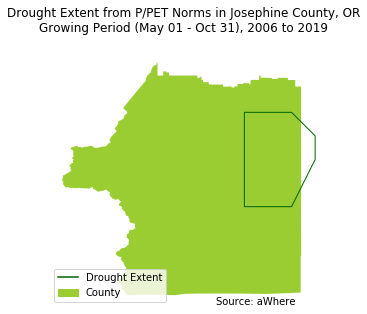

In [13]:
fig, norms = plt.subplots(figsize=(5,5))

# Create title for entire plot set
fig.suptitle("Drought Extent from P/PET Norms in Josephine County, OR\n"+
            "Growing Period (May 01 - Oct 31), 2006 to 2019")

# For norms plot
master_gdf[:1].plot(ax=norms, color="none", edgecolor='darkgreen', zorder=2)
aoi.plot(ax=norms, color='yellowgreen')
norms.text(0.6, 0.01, 'Source: aWhere', transform=norms.transAxes)
norms.axis("off")

# For legend line
extent_line = mlines.Line2D([], [], color='darkgreen', label='Drought Extent')
county_patch = mpatches.Patch(color='yellowgreen', label='County')
norms.legend(handles=[extent_line, county_patch], loc=('lower left'))


plt.show()

#### Spatial Extent Increase
The area experiencing agricultural drought during the approximate growing season (May 01 to Oct 31) has increased in size from 2016 to 2019 to encompass most of Josephine County, Oregon.

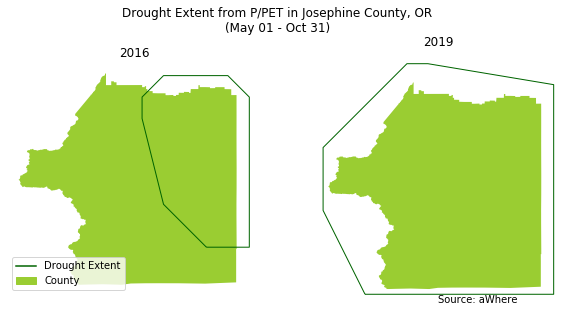

In [14]:
"""For plots showing county and drought extent by area for years 2016 and 2019"""

fig, (y_2016, y_2019) = plt.subplots(1, 2, figsize=(10,5))

# Create title for entire plot set (2 plots)
fig.suptitle("Drought Extent from P/PET in Josephine County, OR\n"+
            "(May 01 - Oct 31)")


# For legend line
extent_line = mlines.Line2D([], [], color='darkgreen', label='Drought Extent')
county_patch = mpatches.Patch(color='yellowgreen', label='County')
y_2016.legend(handles=[extent_line, county_patch], loc=('lower left'))

# For 2016 plot
y_2016.set_title("2016")
master_gdf[2:3].plot(ax=y_2016, color="none", edgecolor='darkgreen', zorder=2)
aoi.plot(ax=y_2016, color='yellowgreen')
y_2016.axis("off")

# For 2019 plot
y_2019.set_title("2019")
master_gdf[5:6].plot(ax=y_2019, color="none", edgecolor='darkgreen', zorder=2)
aoi.plot(ax=y_2019, color='yellowgreen')
y_2019.text(0.5, 0.01, 'Source: aWhere', transform=y_2019.transAxes)
y_2019.axis("off")

plt.show()

#### P/PET Values Descrease
Josephine County has also experienced a downward trend of P/PET during the growing season since 2016. 2018 and 2019 both had values below the historical seasonal P/PET average.

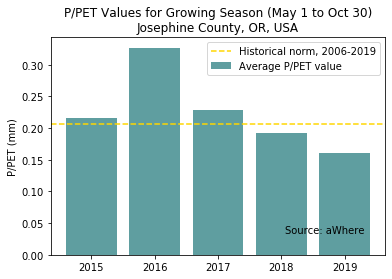

In [15]:
"""For bar chart showing average P/PET values in growing season by year"""

fig, ax = plt.subplots()

ax.set(title="P/PET Values for Growing Season (May 1 to Oct 30)\n" +
       "Josephine County, OR, USA",
      ylabel="P/PET (mm)")

ax.bar(master_gdf[1:].index.values, master_gdf[1:].inferred_ppet,
       color='cadetblue',
       label="Average P/PET value")

# Plot historical norm
ax.axhline(master_gdf[:1].inferred_ppet[0],
           linestyle="--",
           color="gold",
           label='Historical norm, 2006-2019')

ax.text(0.7, 0.1, 'Source: aWhere', transform=ax.transAxes)

ax.legend()
plt.show()

### *Importance of Findings*

---
This study is important because it provides a **reproduicible workflow to quantify** the areas experiencing a particularly severe drought, **as defined by the user**. 

Josephine County has been experiencing severe drought since April 2020 according to the U.S. Drought Monitor. However, this source describes approximate areas affected, and the methods used to derive these areas are opaque. In fact, the U.S. Drought Monitor website itself does not recommend its use to infer specifics about local conditions.

On the other hand, this study allows the user provide a custom time period and a custom drought definition to describe droughts; it is an alternative to the "all-encompasing" nature of U.S. Drought Tracker findings. Thus, the user may explore drought extent and severity according to variables based on their judgment of local conditions. For example, agronomists and farmers can use this script to inform crop placement and rotation using crop-specific values of P/PET. Foresters and land management agents can infer forest and land health. **In sum, climate data exploration is available to  stakeholders with introductory Python knowledge.**

### *Methods*

---

The code that was used to reach these findings performs the following steps:

1. Draws a grid over an area of interest. This is necessary since aWhere returns info for grid cells measuring about 9 km by 9 km. Project partner Cale Kochenour provided this script.
2. Calls aWhere's servers to find precipitation and potential evapotranspiration values in each grid cell
3. Calculates the P/PET for the growing season
4. Draws a shape that covers the largest cluster of droughted cells (with a P/PET of 0.5 and lower)
5. Finds average P/PET and area for this shape, taking into account the cells that are not entirely covered by the shape from step 4.

This image shows the spatial outputs for 2019. Each grid cell that touches Josephine County contains P/PET values. The drought extent is represented as a polygon drawn around the entire county, since every grid cell in the county is lower than the P/PET threshold of 0.5. Because all cells that touch Josephine County are included, the droughted area may extend beyond the county's boundaries.

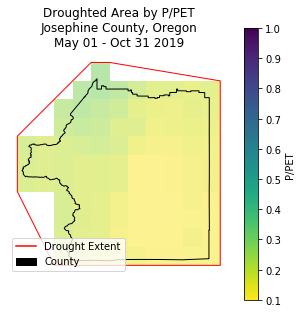

In [16]:
"""Create figure showing intermediate steps to illustrate workflow. 
For ease, show data from final iteration of loop."""

fig, ax = plt.subplots(figsize = (5,5))


ax.set(title="Droughted Area by P/PET\n" + 
       "Josephine County, Oregon\n" + 
       "May 01 - Oct 31 2019")

# Plot county
aoi.plot(color="none", 
               edgecolor="black", 
               ax=ax, 
               zorder=3)

# Plot convex hull for most recent year
master_gdf[-1:].plot(ax=ax, 
                     color="none", 
                     edgecolor="red", 
                     zorder=2)

# Plot last GDF from loop above for most recent year
year_gdf.plot(column='accum_ppet', 
              cmap='viridis_r', 
              ax=ax, 
              vmin=0.1, 
              vmax=1, 
              legend=True, 
              alpha=0.5,
              legend_kwds={'label': "P/PET"})

# Add legend items
extent_line = mlines.Line2D([], [], color='red', label='Drought Extent')
county_line = mpatches.Patch(color='black', label='County')
ax.legend(handles=[extent_line, county_line], loc=('lower left'))

# Turn off axis
ax.axis("off")

plt.show()

### *Discussion*

---

Droughts are difficult to define, let alone quantify. For this study, I chose **P/PET** as the indicator to indicate drought. P/PET is a measurement commonly used to determine aridity and water stress in plants. The "P" in "P/PET" stands for precipitation and "PET" stands for evapotranspiration - the movement of water from soil to the atmosphere. A value of close to 1 indicates that most of the water that has left a system has returned to recharge the groundwater in that system.


![Surface Water Cycle](images/surface_water_cycle.png)

_Image source: Source: Michael W. Toews_


Threshold values of P/PET are as follows. At and below these values, evidence of water stress becomes apparent:

| P/PET | What is affected| 
| ------|---------------|
|  0.4  | Forests and rangeland | 
| 0.6 - 0.8 | Many crops | 
| 0.5 | This study | 

The area chosen was Josephine County, Oregon, a rural county that has been in the midst of a drought in April and May 2020 (according to the U.S. Drought Monitor).

The time period chosen was the approximate growing season, May 1st to October 31st, for the years 2014 through 2019.
 
#### Limitations of study

 - P/PET is a good measure for aridity and crop stress, not necesarily other types of drought.
 - The results are somewhat complex; the drought extent may extend beyond the area of interest.
 - Presence of irrigation systems complicates interpretation of results; crops may not be impacted in a droughted area due to irrigation systems. 

#### Future directions
##### Statistical

 - Use zonal statistics to identify land use types and changes in droughted areas. 
 - Use spatial statistics to determine probability of drought's extent being the result of randomness alone rather than shifts in weather patterns.
 
##### Comparisons

 - Does P/PET change crop productivity? 
 - What is the relationship of P/PET to fire risk and frequency?
 - How does P/PET compare to other indicators of drought?

### *More on droughts and drought tracking*

---

My github repo containing code and other materials, including this blog post, is [available here](https://github.com/dphillips97/drought-tracker).

I referenced the article "An approach to characterize spatio-temporal drought dynamics" in developing the main workflow of this project. This research team goes into depth in their approach to tracking drought centroids; the paper is available [from the publisher](https://www.sciencedirect.com/science/article/pii/S0309170819306542).

The [U.S. Drought Monitor](https://droughtmonitor.unl.edu/) allowed me to easily see areas experiencing drought in the western U.S. The extents displayed on this website are generated from expert judgment of drought-related data.

P/PET threshold values and the agronomics API ([*What is an API?*](https://www.freecodecamp.org/news/what-is-an-api-in-english-please-b880a3214a82/)) were provided by [aWhere](www.awhere.com).